In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import cv2
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Shot_JSON.json", "r") as f:
    annotations = json.load(f)

In [ ]:
print(json.dumps(annotations[100], indent=4))

{
    "id": 102,
    "annotations": [
        {
            "id": 65,
            "completed_by": 2,
            "result": [
                {
                    "value": {
                        "framesCount": 80,
                        "duration": 2.670295,
                        "sequence": [
                            {
                                "frame": 15,
                                "enabled": true,
                                "rotation": 0,
                                "x": 41.85185185185185,
                                "y": 39.166666666666664,
                                "width": 23.703703703703706,
                                "height": 31.166666666666664,
                                "time": 0.5
                            },
                            {
                                "x": 39.777777777777615,
                                "y": 39.16666666666663,
                                "width": 48.88888888888902,
              

EXTRACTING FEATURES FROM THE JSON FILE FOR CNN

In [ ]:
cnn_data = []

for entry in annotations:
    # Extract the video path
    video_path = entry['data'].get('video', entry.get('file_upload'))

    for annotation in entry['annotations']:
        for result in annotation['result']:
            if result['type'] == 'videorectangle':  # Ensure it's a bounding box annotation
                sequence = result['value']['sequence']  # List of bounding box details

                # Extract the frame values for the sequence
                if len(sequence) >= 2:  # Ensure at least two frames are present
                    first_frame = sequence[0]
                    second_frame = sequence[1]
                    frame_gap = second_frame['frame'] - first_frame['frame']  # Calculate the gap

                    frame_info = {
                        "video_path": video_path,
                        "frame_start":first_frame['frame'],
                        "frame_gap": frame_gap,
                        "x": first_frame['x'],
                        "y": first_frame['y'],
                        "width": first_frame['width'],
                        "height": first_frame['height'],
                        "label": result['value']['labels'][0]  # Assuming one label per box
                    }
                    cnn_data.append(frame_info)

# Print extracted frame gap with bounding box details for the first item
print(json.dumps(cnn_data[:2], indent=2))


[
  {
    "video_path": "/data/upload/1/ea8c80e2-ad2662dc-4a3d-49ab-8bae-d73c7c1fad19.mp4",
    "frame_start": 12,
    "frame_gap": 38,
    "x": 40.97877358490566,
    "y": 26.458333333333332,
    "width": 19.45754716981132,
    "height": 68.54166666666667,
    "label": "DRIVE"
  },
  {
    "video_path": "/data/upload/1/2ec6bc1b-7853f0c2-f84e-4a1a-8fad-5866df67aec8.mp4",
    "frame_start": 9,
    "frame_gap": 47,
    "x": 41.214622641509436,
    "y": 10,
    "width": 20.63679245283019,
    "height": 81.875,
    "label": "DRIVE"
  }
]


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

cnn_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import cv2
import numpy as np

def extract_frames_based_on_json(video_path, json_data):
    start_frame = json_data.get("frame_start", 0)
    frame_gap = json_data.get("frame_gap", 0)

    if start_frame < 0 or frame_gap <= 0:
        print("Invalid frame_start or frame_gap: Ensure they are non-negative and greater than 0.")
        return []  # Return an empty list if frame_start or frame_gap is invalid

    print(f"Video path: {video_path}")
    print(f"Starting frame: {start_frame}")
    print(f"Extracting {frame_gap} frames starting from frame {start_frame}")

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return []

    frames = []

    # Extract frames from the starting frame to the range defined by frame_gap
    for frame_num in range(start_frame, start_frame + frame_gap,5):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            # Resize the frame for CNN input
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame {frame_num} from {video_path}")
            break  # Stop if a frame cannot be read

    cap.release()
    return frames


In [ ]:
def extract_cnn_features(frames, cnn_model):

    features = []
    for frame in frames:
        x = np.expand_dims(frame, axis=0)
        x = preprocess_input(x)

        feature = cnn_model.predict(x)
        features.append(feature)

    return np.array(features)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def process_for_lstm(cnn_data, cnn_model):

    X_train = []
    y_train = []

    for video_metadata in cnn_data:
        video_path = video_metadata['video_path']
        video_path = video_path.split('/')[-1].split('-')
        if(len(video_path)>2):
                  video_path='-'.join(video_path[0:])
        else:
                  video_path=video_path[-1]
        if '_1.39.36AM' in video_path:
                  video_path = video_path.replace("_1.39.36AM", "")
        print(video_path)

        frames = extract_frames_based_on_json('/content/drive/MyDrive/all_videos/'+video_path, video_metadata)

        cnn_features = extract_cnn_features(frames, cnn_model)


        label = video_metadata['label']


        X_train.append(cnn_features)
        y_train.append(label)


    X_train_padded = pad_sequences(X_train, dtype='float32', padding='post', value=0.0)
    label_encoder = LabelEncoder()


    y_train_numeric = label_encoder.fit_transform(y_train)

    y_train_encoded = to_categorical(y_train_numeric)

    return X_train_padded, y_train_encoded

In [ ]:
X_train, y_train = process_for_lstm(cnn_data, cnn_model)

ea8c80e2-ad2662dc-4a3d-49ab-8bae-d73c7c1fad19.mp4
Video path: /content/drive/MyDrive/all_videos/ea8c80e2-ad2662dc-4a3d-49ab-8bae-d73c7c1fad19.mp4
Starting frame: 12
Extracting 38 frames starting from frame 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2ec6bc1b-7853f0c2-f84e-4a1a-8fad-5866df67aec8.mp4
Video path: /content/drive/MyDrive/all_videos/2ec6bc1b-7853f0c2-f84e-4a1a-8fad-5866df67aec8.mp4
Starting frame: 9
Extracting 47 frames starting from frame 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
X_train_,X_test,y_train_,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = y_train_.shape[1]

input_shape = (55, 2048)

model = Sequential()

model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
X_train_reshaped = X_train_.squeeze(axis=-2)
model.fit(X_train_reshaped, y_train_, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 55, 128)             │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 55, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,164,227 (4.44 MB)

 Trainable params: 1,164,227 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5183 - loss: 1.0176 - val_accuracy: 0.7600 - val_loss: 0.6263
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8019 - loss: 0.5982 - val_accuracy: 0.9200 - val_loss: 0.2366
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9190 - loss: 0.2709 - val_accuracy: 0.9800 - val_loss: 0.0889
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9596 - loss: 0.1601 - val_accuracy: 1.0000 - val_loss: 0.0449
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9963 - loss: 0.0494 - val_accuracy: 1.0000 - val_loss: 0.0178
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9973 - loss: 0.0305 - val_accuracy: 0.9800 - val_loss: 0.0913
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9981 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9973 - loss: 0.0194 - val_accuracy: 0.9400 - val_loss: 0.2771


In [ ]:
# Assuming you have test data: X_test, y_test
X_test_reshaped = X_test.squeeze(axis=-2)
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9894 - loss: 0.0616
Test Loss: 0.08755747228860855, Test Accuracy: 0.9841269850730896


In [ ]:
from sklearn.metrics import confusion_matrix
predictions=model.predict(X_test_reshaped)
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Assuming you have y_test as true labels

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Confusion Matrix:
[[25  0  0]
 [ 0 20  1]
 [ 0  0 17]]


In [ ]:
model.save('lstm_model_gpu_98.h5')

NameError: name 'model' is not defined

### TESTING CODE

In [ ]:
!pip install ffpyplayer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.2 MB/s eta 0:00:00


In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import cv2
from google.colab import drive
import os
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from ffpyplayer.player import MediaPlayer

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

cnn_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import tensorflow as tf
model=tf.keras.models.load_model('lstm_model_gpu_98.h5')

In [ ]:
def extract_and_preprocess_frames(video_path, frame_rate=5):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Extract frames at specified frame_rate
    for frame_num in range(0, frame_count, frame_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            # Resize and preprocess the frame
            frame_resized = cv2.resize(frame, (224, 224))
            frame_features = extract_features(frame_resized)
            frames.append(frame_features)
        else:
            print(f"Warning: Could not read frame {frame_num} from {video_path}")


    cap.release()

    return np.array(frames)



In [ ]:
def extract_features(frame):

    img = image.img_to_array(frame)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    features = cnn_model.predict(img)

    return features.flatten()

In [ ]:
l=[3671,3742,3821,3681,3654,3672,3791,3508,3836,3777]
l=[3600]

In [ ]:
for i in l:
  video_frames = extract_and_preprocess_frames(f'/content/drive/MyDrive/all_videos/IMG_{i}.mp4')
  pred_labels=['CUT','DRIVE','SWEEP']
  if video_frames is not None:

        num_frames = video_frames.shape[0]
        feature_dim = video_frames.shape[1]

        print(f"Number of frames: {num_frames}, Feature dimension: {feature_dim}")

        if feature_dim == 2048:
            video_frames_reshaped = video_frames.reshape(1, num_frames, feature_dim)

            # Make the prediction
            predictions = model.predict(video_frames_reshaped)
            print(f"Predictions for new video: {predictions}")

            print(pred_labels[np.argmax(predictions)])

        else:
            print(f"Feature dimension mismatch. Expected 2048 but got {feature_dim}.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Number of frames: 21, Feature dimension: 2048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Predictions for new video: [[0.86774707 0.07603254 0.05622044]]
CUT


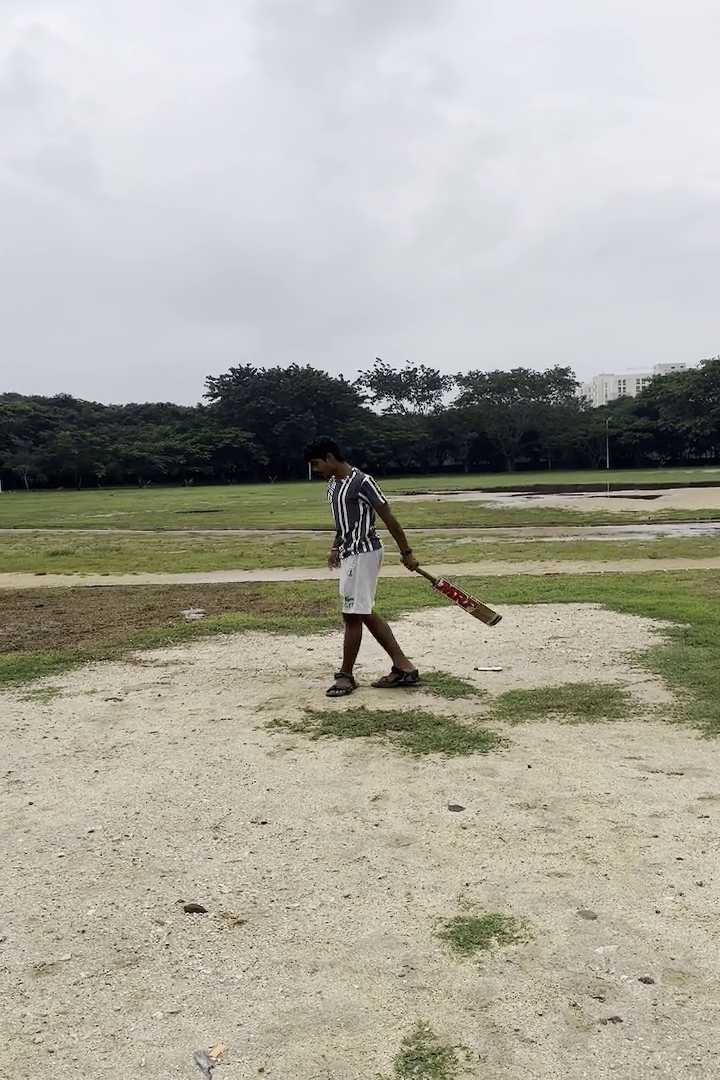

End of video


In [ ]:
import cv2
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

video_path = f'/content/drive/MyDrive/all_videos/IMG_3600.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")

# Get the video FPS (frames per second)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_delay = 1 / fps  # Time delay between frames

print(f"Video FPS: {fps}, Frame Delay: {frame_delay:.2f} seconds")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video")
        break

    clear_output(wait=True)  # Clear the previous frame
    cv2_imshow(frame)  # Display the current frame

    # Introduce delay to match video FPS
    time.sleep(frame_delay)

cap.release()
